# **Task**



Using t-SNE to build a two-dimensional representation of the dataset and determine the number of clusters

Train at least 2 clustering models

Select the optimal number of clusters using at least 2 metrics

#Import libraries

In [1]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#install clustergran
!pip install clustergram

#install dbcv metric
!pip install "git+https://github.com/christopherjenness/DBCV"

  Cloning https://github.com/christopherjenness/DBCV to /tmp/pip-req-build-blyf2cmr
  Running command git clone --filter=blob:none --quiet https://github.com/christopherjenness/DBCV /tmp/pip-req-build-blyf2cmr
  Resolved https://github.com/christopherjenness/DBCV to commit db7345c45ab7d33ea500778e5c9048fd9f7d3156
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from clustergram import Clustergram

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from DBCV import DBCV

from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score


# load data

In [4]:
#randeom seed
seed = 42

#scaler

scaler = StandardScaler()

#columns names
names = ["status", "duration", "credit_history","purpose","amount","savings",
         "employment_duration","installment_rate","personal_status_sex",
         "other_debtors","present_residence`","property","age",
         "other_installment_plans","housing","number_credits","job",
         "people_liable","telephone","foreign_worker", "credit_risk"]

# data path
path = "/content/drive/MyDrive/Hillel_ML_Course/11/SouthGermanCredit.asc"

In [5]:
#load data with changed column name, delimiter "space" and without old columns
data = pd.read_csv(path, names=names,  sep=" ", header=0)

In [6]:
data.head()

status  duration  credit_history  purpose  amount  savings  \
0       1        18               4        2    1049        1   
1       1         9               4        0    2799        1   
2       2        12               2        9     841        2   
3       1        12               4        0    2122        1   
4       1        12               4        0    2171        1   

   employment_duration  installment_rate  personal_status_sex  other_debtors  \
0                    2                 4                    2              1   
1                    3                 2                    3              1   
2                    4                 2                    2              1   
3                    3                 3                    3              1   
4                    3                 4                    3              1   

   ...  property  age  other_installment_plans  housing  number_credits  job  \
0  ...         2   21                        3        1               1    3   
1  ...         1   36                        3        1               2    3   
2  ...         1   23                        3        1               1    2   
3  ...         1   39                        3        1               2    2   
4  ...         2   38                        1        2               2    2   

   people_liable  telephone  foreign_worker  credit_risk  
0              2          1               2            1  
1              1          1               2            1  
2              2          1               2            1  
3              1          1               1            1  
4              2          1               1            1  

[5 rows x 21 columns]

# observation dataset

In [7]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1000 non-null   int64
 1   duration                 1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   amount                   1000 non-null   int64
 5   savings                  1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   other_debtors            1000 non-null   int64
 10  present_residence`       1000 non-null   int64
 11  property                 1000 non-null   int64
 12  age                      1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  housing                  1000 non-null   int64
 15  numbe

In [8]:
# check nan values in dataset
data.isna().sum()

status                     0
duration                   0
credit_history             0
purpose                    0
amount                     0
savings                    0
employment_duration        0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence`         0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
credit_risk                0
dtype: int64

#TSNE

function to make analysis easy

In [9]:
def tsne_plot(columns_name):
    """Function checks how many columns are in the argument,
       creates an empty dictionary, calculates unique values
       and adds them to the dictionary with colors, then creates a t-SNE plot with these values."""

    # Create color dictionary
    color_dict = {}

    # Unique values list
    uniq_list = set()

    # Color list
    colors = ["orange", "blue", "red", "black", "gray", "pink"]

    colum_len = len(columns_name)

    # Iterate over unique values and color list
    for val in columns_name:
        uniq_list.update(data[val].unique())
    for i, j in zip(uniq_list, colors):
        color_dict[i] = j

    # Create plots
    if colum_len == 1:
        plt.figure(figsize=(10, 6))
        plt.scatter(data_repr[:, 0], data_repr[:, 1], c=data[columns_name].map(color_dict), alpha=0.5)

        # Legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(key), markerfacecolor=value, markersize=10) for key, value in color_dict.items()]
        plt.legend(title="Categories", handles=handles)
        plt.title(columns_name[0])  # Add title
        plt.show()

    else:
        n = len(columns_name)
        ncols = 3  # Number of columns
        nrows = (n + ncols - 1) // ncols  # Calculate number of rows

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

        for i, name in enumerate(columns_name):
            ax = axes[i // ncols, i % ncols]  # Select subplot
            ax.scatter(data_repr[:, 0], data_repr[:, 1], c=data[name].map(color_dict), alpha=0.5)
            ax.set_title(name)

            # Legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(key), markerfacecolor=value, markersize=10) for key, value in color_dict.items()]
            ax.legend(title="Categories", handles=handles)

        # Remove excess plots if fewer than nrows*ncols
        for j in range(n, nrows * ncols):
            fig.delaxes(axes[j // ncols, j % ncols])

        plt.show()


In [10]:
#scale data

data_scaled = scaler.fit_transform(data)

In [11]:
tsne = TSNE(random_state=42)

In [12]:
# make data representation by tsne

data_repr = tsne.fit_transform(data_scaled)

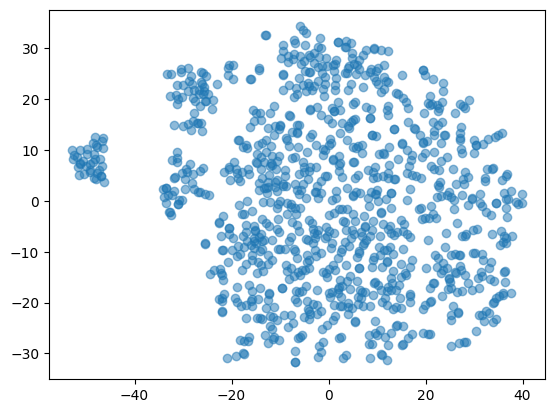

In [13]:
# plot data
plt.scatter(data_repr[:, 0], data_repr[:, 1], alpha=0.5)

Let's see representation according to the credit risk

blue with bad and orange with good credit risk

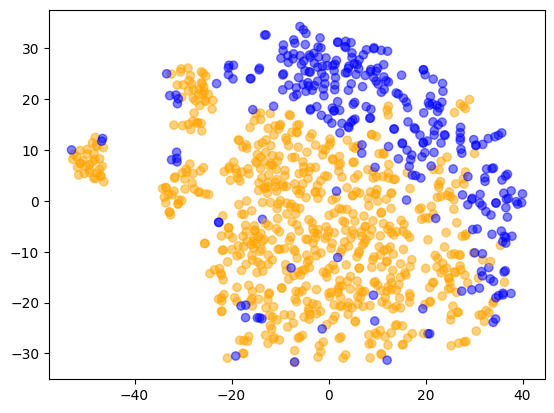

In [14]:
plt.scatter(
    data_repr[:, 0],
    data_repr[:, 1],
    c=data["credit_risk"].map({0: "blue", 1: "orange"}),
    alpha=0.5,
);

from this plot we can see that some people with good credit risk concentrated in area people with bad credit risk and opposit(but here can be outliers)

and after we can see on the other binary columns : foreigin worker and telephone orange - yes, blue - no

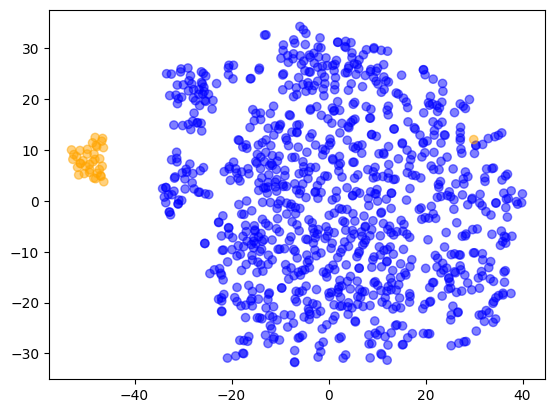

In [15]:
plt.scatter(
    data_repr[:, 0],
    data_repr[:, 1],
    c=data["foreign_worker"].map({2: "blue", 1: "orange"}),
    alpha=0.5,
);

foreigin workeres are in other cluster

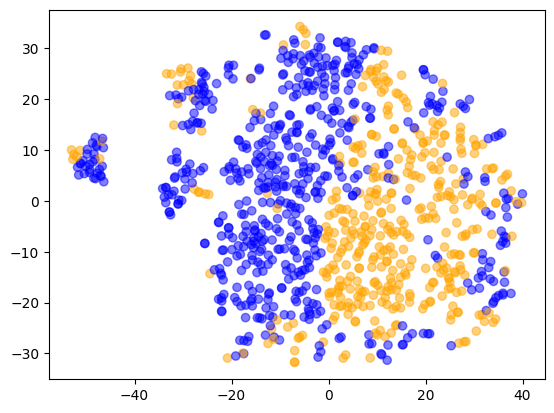

In [16]:
plt.scatter(
    data_repr[:, 0],
    data_repr[:, 1],
    c=data["telephone"].map({1: "blue", 2: "orange"}),
    alpha=0.5,
)

from this polt we see that telephone featurecan concentrates in many spaces

After few attemps i decided to write function for plot t-snee graphs with automatic colors and values

In [17]:
data.columns

Index(['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
       'employment_duration', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'present_residence`', 'property', 'age',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk'],
      dtype='object')

In [18]:
tsnee_names = ['status', 'credit_history','savings',
       'employment_duration', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'present_residence`', 'property',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk']

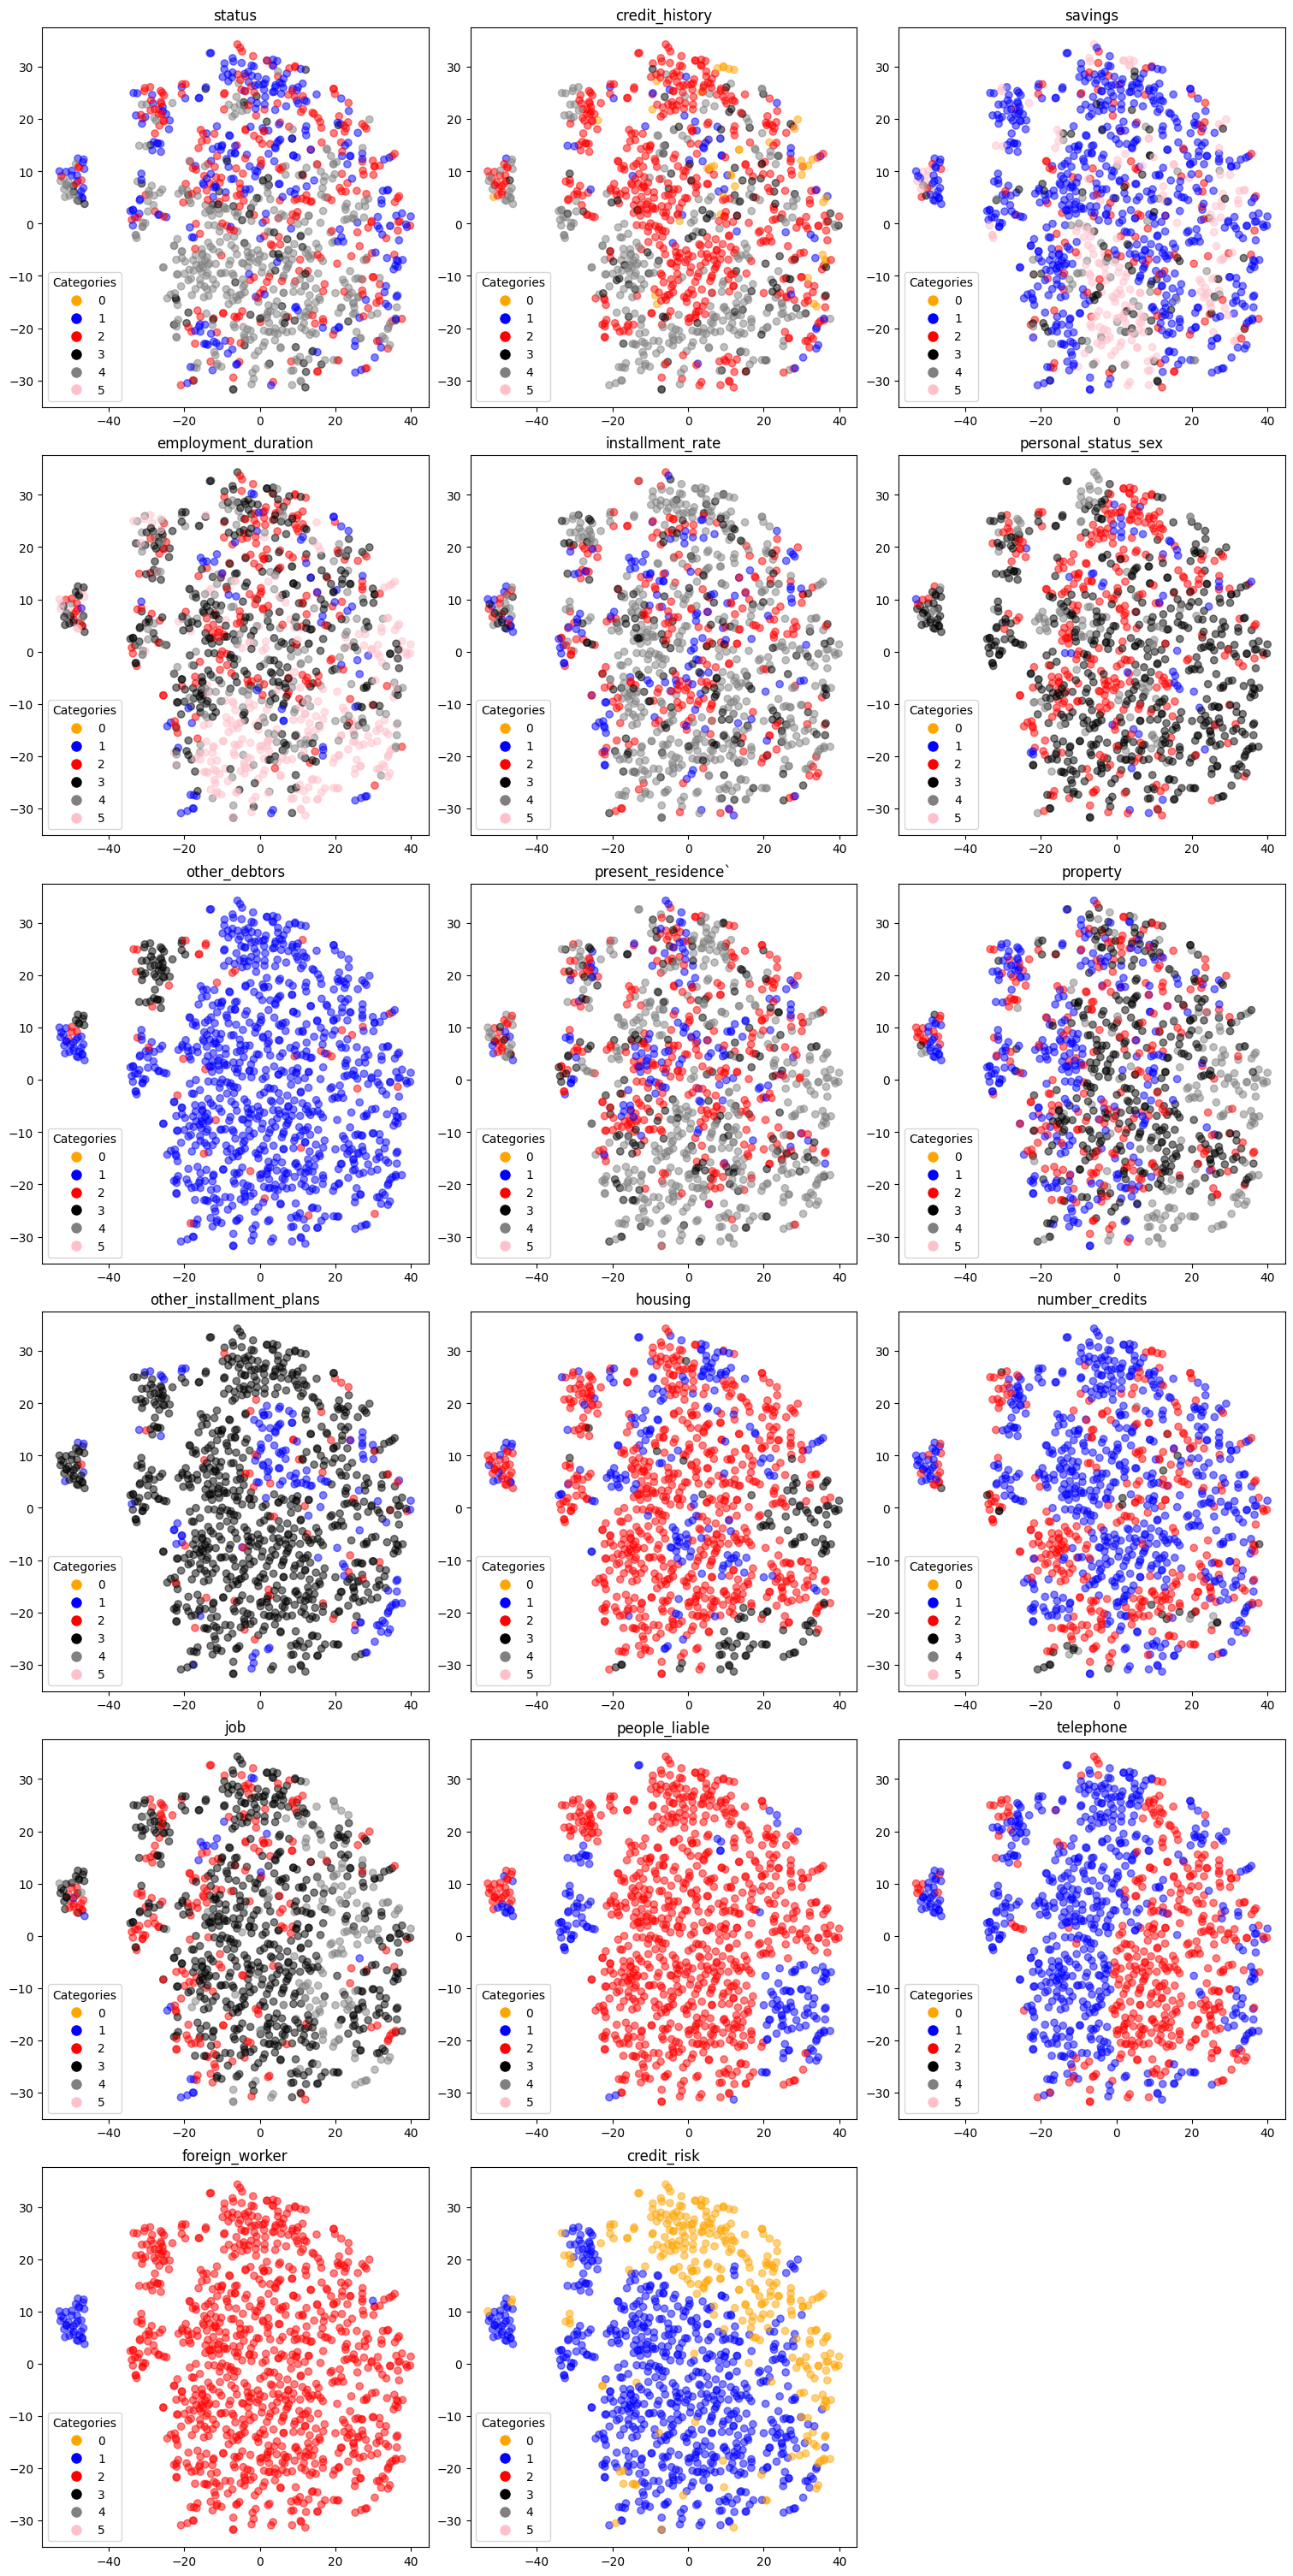

In [19]:
tsne_plot(tsnee_names)

## summary:

from tsnee fraphs we see that,

it make foreigin worker in another cluster

other debtors column ---- ( in cluster as garant person)

people liable ----  by 3 or more peoples



#K means

## find clusters

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.014 seconds.
K=3 fitted in 0.023 seconds.
K=4 fitted in 0.011 seconds.
K=5 fitted in 0.032 seconds.
K=6 fitted in 0.024 seconds.
K=7 fitted in 0.022 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

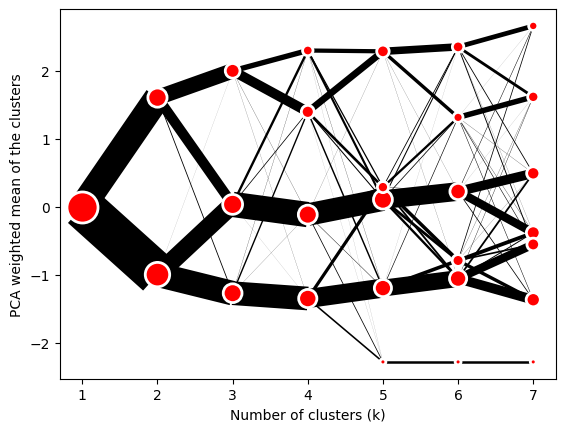

In [20]:
#plot clustergram
cgram = Clustergram(range(1, 8), random_state=seed)
cgram.fit(data_scaled)
cgram.plot()

from this clustergram i decided to define 4 clusters to K-means

#Train K-means

In [42]:
#define Kmeans
kmeans = KMeans(n_clusters=4, random_state=seed)

In [43]:
#fit_transform and define it to variable
k_means_repr = kmeans.fit_transform(data_scaled)

In [44]:
#add predictions to variable
k_means_pred = kmeans.fit_predict(data_scaled)

Text(0.5, 1.0, 'Clusters determined by KMEANS')

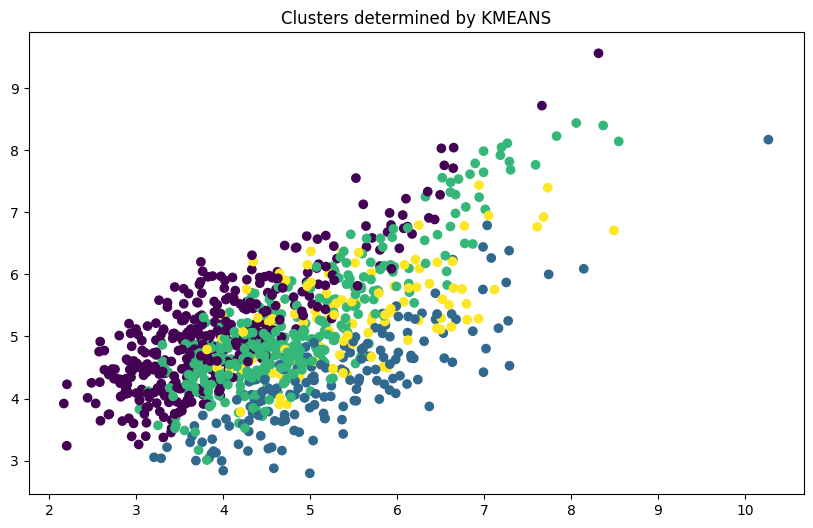

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(k_means_repr[:,0], k_means_repr[:,1],c=k_means_pred)
plt.title("Clusters determined by KMEANS")

#dbscan

i tried technic from [DBSCAN Parameter Estimation Using Python](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd)

##finding epsilon
This technique calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value you selected. The average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature (i.e. where the graph has the greatest slope).

In [25]:
#Calculate the average distance between each point in the data set and its 20 nearest neighbors (my selected MinPts value)
neighbors = NearestNeighbors(n_neighbors=42)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)

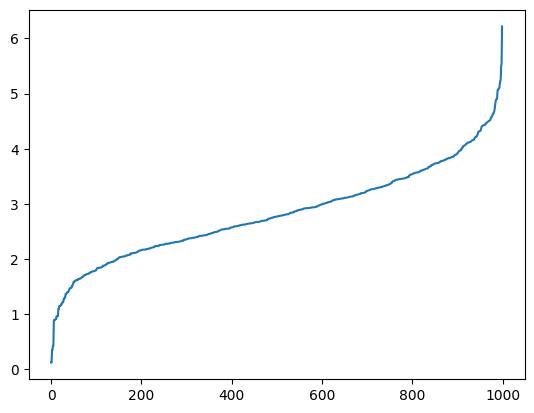

In [26]:
# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

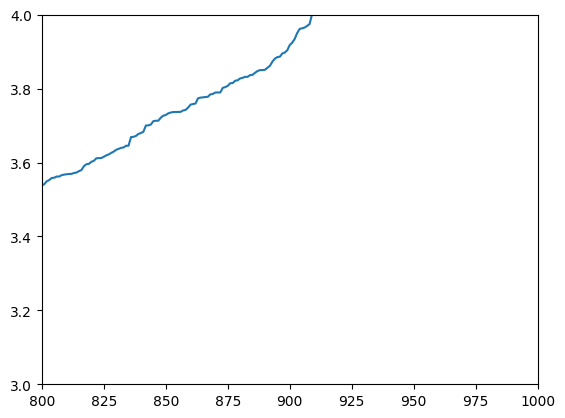

In [27]:
# scale previous image

import numpy as np
import matplotlib.pyplot as plt

distances = np.sort(distances, axis=0)

plt.plot(distances)


plt.xlim(800, 1000)
plt.ylim(3, 4)

plt.show()


Zooming in on my k-distance plot, it looks like the optimal value for ε is around 3,82. I ended up looping through combinations of MinPts and ε values slightly above and below the values estimated here to find the model of best fit.

#Train DBSCAN

In [28]:
#define DBscan
db_cluster = DBSCAN(eps=3.82)

In [29]:
#define predict
db_predict = db_cluster.fit_predict(data_scaled)

In [30]:
#print out
print(set(db_predict))

{0, 1, -1}


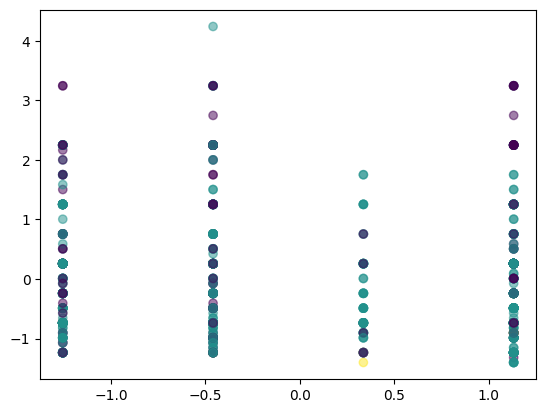

In [31]:
#plot our clusters
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], alpha=0.5, c=db_predict)

# Evaluate models

In [46]:
#k-means score
kmeans_score = DBCV(data_scaled, k_means_pred, dist_function=euclidean)
print(f" the DBCV score of k-means is: {kmeans_score}")

 the DBCV score of k-means is: -0.5996445980908913


In [47]:
# DBCV score
hdbscan_score = DBCV(data_scaled, db_predict, dist_function=euclidean)
print(f" the DBCV score of k-means is: {hdbscan_score}")

 the DBCV score of k-means is: -0.2818754969122571


In [48]:
#silhouette score
kmeans_sil_score = silhouette_score(data_scaled, k_means_pred)
hdbscan_sil_score = silhouette_score(data_scaled, db_predict)
print(f" the silhouette score of k-means is: {kmeans_sil_score} \n",
      f"the silhouette score of dbscan is: {hdbscan_sil_score}")

 the silhouette score of k-means is: 0.07113637981973492 
 the silhouette score of dbscan is: 0.15064550111875089


#Conclusion

by evaluation with 2 metrics the better model on this data is DBSCAN